<img src="https://i.imgur.com/AKoq3Wt.png" width=1200 />



## **🎯      Goal**


For 10 different fruits, decide the bounding box, the labels and their score.

<img src="https://i.imgur.com/ezUEsNr.png" width=800 />



## **1**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Import Libraries**


In [ ]:
!pip install pytorch-lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.3 MB/s eta 0:00:00


In [ ]:
# DATA MANIPULATION
import pandas as pd         # Data manipulation and analysis.
import numpy as np          # Numerical operations and arrays.

# DATA MANAGEMENT
import zipfile              # Reading and writing zip files.
import requests             # Sending HTTP requests (downloading files from the internet).
import io                   # Handling I/O streams (working with byte streams, buffers).
import os                   # Interacting with the operating system (file and directory operations).
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

# IMAGE PROCESSING
from PIL import Image       # Opening, manipulating, and saving image files.

### Making Preprocessing Functions

In [ ]:
def extract_annotations(annotation_path, image_file):
    with open(annotation_path, 'r') as file:
        annotations = file.readlines()

    boxes = []
    labels = []

    # Extract the fruit name from the image filename
    fruit_name = os.path.splitext(image_file)[0].split('_')[1]

    for annotation in annotations:
        values = annotation.strip().split()
        xmin, ymin, xmax, ymax = map(float, values[1:])
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(fruit_name)

    return boxes, labels

In [ ]:
## Visualization of the Image, Bounding Box, and Score

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def yolobbox2bbox(x, y, w, h, image_width, image_height):
    x1 = (x - w/2) * image_width
    y1 = (y - h/2) * image_height
    x2 = (x + w/2) * image_width
    y2 = (y + h/2) * image_height
    return x1, y1, x2, y2

def visualize_results(df, num_rows=3, num_cols=3, test_mode=False):
    num_images = num_rows * num_cols
    sample_df = df.sample(n=num_images, replace=num_images > len(df))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2, num_rows*2))
    axes = axes.flatten()

    for ax, row in zip(axes, sample_df.itertuples()):
        image = row.image
        width, height = image.size
        ax.imshow(image)

        for box, label in zip(row.boxes, row.labels):
            x, y, w, h = box

            # Convert YOLO format to standard format
            xmin, ymin, xmax, ymax = yolobbox2bbox(x, y, w, h, width, height)

            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)

            text = f"{label}: {row.scores[row.labels.index(label)]:.3f}" if test_mode else label
            ax.text(xmin, ymin, text, color='black', fontsize=8, ha='left', va='top',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

        ax.set_title(row.image_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## **2**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Load Training Dataset**



In [ ]:
# Get the file URL
train_url = "https://www.dropbox.com/scl/fi/ogkpfsddlxfgpwwyabqp5/train_10fruits.zip?rlkey=25vmsgxzyryfnfhd27mtrcs6p&st=vw9i5cs7&dl=0&raw=1"

# Extract zip file
zipfile.ZipFile(io.BytesIO(requests.get(train_url).content)).extractall()

# Remove spaces and convert filenames to lowercase
files = os.listdir('train')
for file in files:
    new_file = file.replace(' ', '').lower()
    os.rename(os.path.join('train', file), os.path.join('train', new_file))

# Get the updated list of image files
image_files = [f for f in os.listdir('train') if f.endswith('.jpg') or f.endswith('.jpeg')]

# Create a list to store the data
data = []

for image_file in image_files:
    image_path = os.path.join('train', image_file)
    annotation_path = os.path.splitext(image_path)[0] + '.txt'

    image = Image.open(image_path).convert('RGB')
    boxes, labels = extract_annotations(annotation_path, image_file)

    data.append({"image_name": image_file, "image": image, "boxes": boxes, "labels": labels})

# Create a DataFrame from the data
train_df = pd.DataFrame(data)

# Print the DataFrame
print(train_df.head())

         image_name                                              image  \
0      26_apple.jpg  <PIL.Image.Image image mode=RGB size=564x681 a...   
1     29_papaya.jpg  <PIL.Image.Image image mode=RGB size=564x752 a...   
2      25_apple.jpg  <PIL.Image.Image image mode=RGB size=563x441 a...   
3      14_apple.jpg  <PIL.Image.Image image mode=RGB size=564x846 a...   
4  09_jackfruit.jpg  <PIL.Image.Image image mode=RGB size=754x565 a...   

                                        boxes       labels  
0   [[0.589666, 0.67913, 0.312886, 0.248696]]      [apple]  
1  [[0.470319, 0.538261, 0.881159, 0.913043]]     [papaya]  
2  [[0.515257, 0.473913, 0.820085, 0.822609]]      [apple]  
3       [[0.753565, 0.58, 0.45913, 0.391304]]      [apple]  
4  [[0.291114, 0.480088, 0.517241, 0.650442]]  [jackfruit]  


### Visualize the Training Dataset

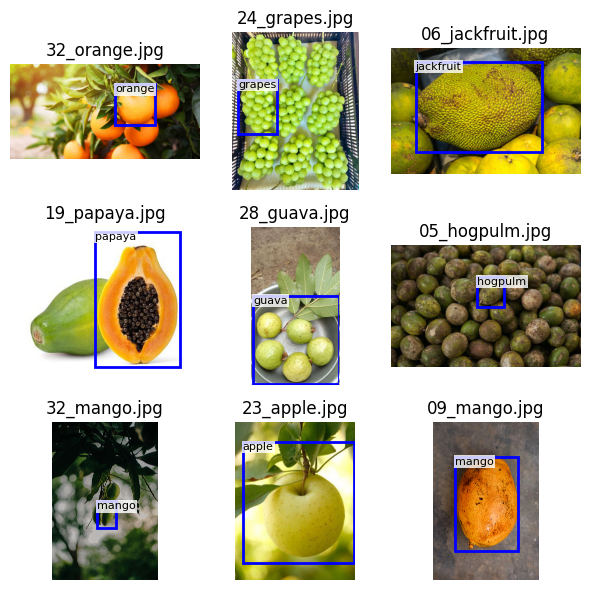

In [ ]:
visualize_results(train_df, num_rows=3, num_cols=3, test_mode=False)

## **3**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Create Dataset Class**

In [ ]:
import torch
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as T

# Define the dataset class
image_size = 90
label_dict =label_dict = {'banana': 1, 'apple': 2, 'orange': 3, 'lichi': 4, 'guava': 5, 'papaya': 6, 'jackfruit': 7, 'hogplum': 8, 'mango': 9, 'grapes': 10}

class FruitDataset(Dataset):
    def __init__(self, dataframe, has_label=True):
        self.dataframe = dataframe
        self.has_label = has_label
        self.original_sizes = [row['image'].size for _, row in dataframe.iterrows()]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = T.Resize((image_size, image_size))(row['image'])
        image = T.ToTensor()(image)

        if self.has_label:
            boxes = torch.as_tensor(row['boxes'], dtype=torch.float32)
            labels = torch.as_tensor([label_dict[label] for label in row['labels']], dtype=torch.int64)

            # Scale bounding box coordinates
            scale_factors = torch.as_tensor([image_size / self.original_sizes[idx][0], image_size / self.original_sizes[idx][1]], dtype=torch.float32)
            boxes[:, [0, 2]] *= scale_factors[0]
            boxes[:, [1, 3]] *= scale_factors[1]

            return image, {'boxes': boxes, 'labels': labels}
        else:
            return image


## **4**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Create Training Set**


In [ ]:
from torch.utils.data import DataLoader

dataset = FruitDataset(train_df)

train_loader = DataLoader(dataset, batch_size=2, num_workers=3, shuffle=True,
                          collate_fn=lambda batch: tuple(zip(*batch)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **5**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Create Neural Network Class**

In [ ]:
import torch
import pytorch_lightning as pl
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
torch.cuda.empty_cache()

class FruitDetector(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.model = self.get_pretrained_model(num_classes)

    def get_pretrained_model(self, num_classes):
        # Feature extraction
        model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        for param in model.parameters():  # All the parameters of the pretrained model are set to requires_grad = False,
            param.requires_grad = False   #  which freezes the pretrained weights and prevents them from being updated during training.
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = sum(loss_dict.values())
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Create the neural network
model = FruitDetector(num_classes=len(label_dict)+1)  # 3 labels + 1 background

import torch
import pytorch_lightning as pl
from torchvision.models.detection import fasterrcnn_resnet50_fpn, fasterrcnn_mobilenet_v3_large_fpn, fasterrcnn_mobilenet_v3_large_320_fpn, retinanet_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
torch.cuda.empty_cache()

class FruitDetector(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.model = self.get_pretrained_model(num_classes)

    def get_pretrained_model(self, num_classes):
        # # Faster R-CNN with ResNet-50 FPN
        # model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        # for param in model.parameters():  # All the parameters of the pretrained model are set to requires_grad = False
        #     param.requires_grad = False   #  which freezes the pretrained weights and prevents them from being updated during training.
        # in_features = model.roi_heads.box_predictor.cls_score.in_features
        # model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # Faster R-CNN with MobileNet V3 Large FPN
        model = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
        for param in model.parameters():
            param.requires_grad = False
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # Faster R-CNN with MobileNet V3 Large 320 FPN
        # model = fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")
        # for param in model.parameters():
        #     param.requires_grad = False
        # in_features = model.roi_heads.box_predictor.cls_score.in_features
        # model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # RetinaNet with ResNet-50 FPN
        # model = retinanet_resnet50_fpn(weights="DEFAULT")
        # for param in model.parameters():
        #     param.requires_grad = False
        # model.head.classification_head.cls_logits = torch.nn.Conv2d(256, num_classes, kernel_size=3, stride=1, padding=1)

        return model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = sum(loss_dict.values())
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Create the neural network
model = FruitDetector(num_classes=len(label_dict)+1)  # 3 labels + 1 background

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 169MB/s]


## **6**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Train the Neural Network**

In [ ]:
from pytorch_lightning.loggers import CSVLogger

# Configure the logger
logger = CSVLogger("logs", name="object_detector")

# Train the model using PyTorch Lightning
trainer = pl.Trainer(max_epochs=50, logger=logger)
trainer.fit(model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 19.0 M | train
---------------------------------------------
56.4 K    Trainable params
18.9 M    Non-trainable params
19.0 M    Total params
75.905    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might g

Training: |          | 0/? [00:00<?, ?it/s]

AssertionError: All bounding boxes should have positive height and width. Found invalid box [0.5238354802131653, 0.4450227618217468, 0.6004156470298767, 0.3929533362388611] for target at index 0.

## **7**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Load the Testset**

In [ ]:
# Get the file URL
test_url = "https://www.dropbox.com/scl/fi/5qtolnnhbvtvk2ac1twln/test_10fruits.zip?rlkey=izygljeahy1azr24sd0rwnxjx&st=i4vm99af&dl=0&raw=1"

# Extract zip file
zipfile.ZipFile(io.BytesIO(requests.get(test_url).content)).extractall()

# Remove spaces and convert filenames to lowercase
files = os.listdir('test')
for file in files:
    new_file = file.replace(' ', '').lower()
    os.rename(os.path.join('test', file), os.path.join('test', new_file))

# Get the updated list of image files
image_files = [f for f in os.listdir('test') if f.endswith('.jpg') or f.endswith('.jpeg')]

# Create a list to store the data
data = []

for image_file in image_files:
    image_path = os.path.join('test', image_file)
    annotation_path = os.path.splitext(image_path)[0] + '.txt'

    image = Image.open(image_path).convert('RGB')
    boxes, labels = extract_annotations(annotation_path, image_file)

    data.append({"image_name": image_file, "image": image, "boxes": boxes, "labels": labels})

# Create a DataFrame from the data
test_df = pd.DataFrame(data)

# Print the DataFrame
print(test_df.head())

## **8**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Make Prediction**

In [ ]:
# List of possible fruit labels
fruits = ['banana', 'apple', 'guava', 'litchi', 'hogplum', 'mango', 'papaya', 'grapes', 'orange', 'jackfruit']

# Get the list of image names from the test DataFrame
image_names = test_df['image_name'].tolist()

# Create a list of tuples with (image_name, label, score)
random_predictions = [(image_name, [np.random.choice(fruits)], [np.random.rand()])
                      for image_name in image_names]

# Convert the list of tuples to a pandas DataFrame
prediction_df = pd.DataFrame(random_predictions, columns=['image_name', 'labels', 'score'])

# Print the first few rows of the DataFrame
print(prediction_df.head())

### Visualize the Predictions


## **9**<font color="#FF8888">   ▝</font><font color="#707DA0">▖   </font>**Create Submission File**


In [ ]:
# Save the predictions to a CSV file
prediction_df.to_csv('submission.csv', index=False)

prediction_df

## <font color="#FF8888">▝</font><font color="#707DA0">▖   </font>**Download File**

In [ ]:
from google.colab import files
files.download('submission.csv')